In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Collect all image names (before rotation, before thumbnail generation)

In [5]:
# FOR CHATM2

# The set of dirs where we should search for image files.
raw_data_dirs = \
{('Ntb', 'raw'): '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_Ntb',
('CHAT', 'raw'): '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_CHAT',
('AF', 'raw'): '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_AF',
('Ntb', 'thumbnail'): None}

# image_name_to_metainfo_mapping = '%(brain_id)s_slide%(slide_num)d_%(year)s_%(month)s_%(day)s_S%(scene_index)d'

# image_name_to_metainfo_re_pattern = '(.*?)_slide([0-9]*?)_([0-9]*?)_([0-9]*?)_([0-9]*?)-S([0-9])'
# image_name_to_metainfo_re_semantics = ['brain_id', 'slide_num', 'year', 'month', 'day', 'scene_index']

# g = re.search(image_name_to_metainfo_re_pattern, img_name)
# groups = g.groups()
# dict(zip(image_name_to_metainfo_re_semantics, groups))

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{('Ntb', 'raw'): \
 '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_Ntb/(.*)_.*?_.*?.tif',
 ('CHAT', 'raw'): \
 '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_CHAT/(.*)_.*?_.*?.tif', 
 ('AF', 'raw'): \
 '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_AF/(.*)_.*?_.*?.tif', 
}

In [13]:
# FOR CHATM3

# The set of dirs where we should search for image files.
raw_data_dirs = \
{('Ntb', 'raw'): '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_Ntb',
('CHAT', 'raw'): '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_CHAT',
('AF', 'raw'): '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_AF',
('Ntb', 'thumbnail'): None}

# image_name_to_metainfo_mapping = '%(brain_id)s_slide%(slide_num)d_%(year)s_%(month)s_%(day)s_S%(scene_index)d'

# image_name_to_metainfo_re_pattern = '(.*?)_slide([0-9]*?)_([0-9]*?)_([0-9]*?)_([0-9]*?)-S([0-9])'
# image_name_to_metainfo_re_semantics = ['brain_id', 'slide_num', 'year', 'month', 'day', 'scene_index']

# g = re.search(image_name_to_metainfo_re_pattern, img_name)
# groups = g.groups()
# dict(zip(image_name_to_metainfo_re_semantics, groups))

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{('Ntb', 'raw'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_Ntb/(.*)_.*?_.*?.tif',
 ('CHAT', 'raw'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_CHAT/(.*)_.*?_.*?.tif', 
 ('AF', 'raw'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_AF/(.*)_.*?_.*?.tif', 
}

In [6]:
image_names_all_data_dirs_flattened = set([])
image_names_all_data_dirs = {}
for vr, data_dir in raw_data_dirs.iteritems():
    if data_dir is None: continue
    image_names = set([])
    if vr in input_image_filename_to_imagename_re_pattern_mapping:
        for fn in os.listdir(data_dir):
            g = re.search(input_image_filename_to_imagename_re_pattern_mapping[vr], os.path.join(data_dir, fn))
            img_name = g.groups()[0]
            image_names.add(img_name)
            image_names_all_data_dirs_flattened.add(img_name)
    image_names_all_data_dirs[vr] = image_names
    
    
# Make sure the every image has all three channels.
for vr, img_names in image_names_all_data_dirs.iteritems():
    print vr, 'missing:' 
    print image_names_all_data_dirs_flattened - img_names
    print 

('CHAT', 'raw') missing:
set([])

('Ntb', 'raw') missing:
set([])

('AF', 'raw') missing:
set([])



In [7]:
print len(image_names_all_data_dirs_flattened), 'images are found.'

236 images are found.


In [8]:
# _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
# valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
valid_filenames = sorted(list(image_names_all_data_dirs_flattened), key=lambda n: int(n.split('_')[1][5:]))
# Do not need sorted list at this stage. Simply sort by slide number for ease of examination.

# Specify paths of raw data (original orientation)

These are data that have not been rotated to standard orientation.
so they are not stored into the standard location.

In [9]:
# FOR CHATM2

orig_orientation_image_name_to_filepath_mappings = {
    ('Ntb', 'raw'): \
     '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_Ntb/%(image_name)s_lossless_Ntb.tif',
     ('Ntb', 'thumbnail'): \
     '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_thumbnail_Ntb/%(image_name)s_thumbnail_Ntb.tif',
     ('CHAT', 'raw'): \
     '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_raw_CHAT/%(image_name)s_lossless_CHAT.tif',  
    ('NtbNormalized', 'thumbnail'): \
 '/media/yuncong/BethandHannah_External1/CHATM2/CHATM2_thumbnail_NtbNormalized/%(image_name)s_thumbnail_NtbNormalized.tif'
}

In [17]:
# FOR CHATM3

orig_orientation_image_name_to_filepath_mappings = {
    ('Ntb', 'raw'): \
     '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_Ntb/%(image_name)s_lossless_Ntb.tif',
     ('Ntb', 'thumbnail'): \
     '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_thumbnail_Ntb/%(image_name)s_thumbnail_Ntb.tif',
     ('CHAT', 'raw'): \
     '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_CHAT/%(image_name)s_lossless_CHAT.tif',  
    ('NtbNormalized', 'thumbnail'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_thumbnail_NtbNormalized/%(image_name)s_thumbnail_NtbNormalized.tif'
}

# Generate thumbnails (original orientation)

In [18]:
thumbnail_downscale_factor = 32

In [12]:
for img_name in valid_filenames:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = orig_orientation_image_name_to_filepath_mappings[('Ntb', 'raw')] % {'image_name': img_name}
    out_fp = orig_orientation_image_name_to_filepath_mappings[('Ntb', 'thumbnail')] % {'image_name': img_name}
    create_parent_dir_if_not_exists(out_fp)
    
    img = imread(in_fp)
    imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

    # Alternative: ImageMagick introduces an artificial noisy stripe in the output image.
#     cmd = 'convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp}
#     execute_command(cmd)
        
    sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2543: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return numpy.fromstring(x, typecode)
Rescale: 36.17 seconds.
Rescale: 33.19 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2546: UserWarning: unpack: string size must be a multiple of element size
  warnings.warn("unpack: %s" % e)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2549: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return numpy.fromstring(x[:xlen], typecode)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile

KeyboardInterrupt: 

# Contrast stretch thumbnails (original orientation)

In [ ]:
for img_name in valid_filenames:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = orig_orientation_image_name_to_filepath_mappings[('Ntb', 'thumbnail')] % {'image_name': img_name}
    out_fp = orig_orientation_image_name_to_filepath_mappings[('NtbNormalized', 'thumbnail')] % {'image_name': img_name}
    create_parent_dir_if_not_exists(out_fp)
        
    cmd = """convert "%(in_fp)s" -normalize -depth 8 "%(out_fp)s" """ % {'in_fp': in_fp, 'out_fp': out_fp}
    execute_command(cmd)
    
    sys.stderr.write("Intensity normalize: %.2f seconds." % (time.time() - t))

# Rotate to standard orientation
Top is dorsal, left is anterior

In [10]:
if stack == 'CHATM2':
    image_filename_to_orientation_mapping = \
    {
        img_name: 'top_posterior_left_ventral' for img_name in valid_filenames
    }
elif stack == 'CHATM3':
    image_filename_to_orientation_mapping = {}
    for img_name in valid_filenames:
        if img_name == 'CHATM3_slide07_2018_02_18-S1':
            image_filename_to_orientation_mapping[img_name] = 'top_posterior_left_ventral'
        else:
            image_filename_to_orientation_mapping[img_name] = 'top_anterior_left_dorsal'

In [41]:
# for img_name in valid_filenames:

#     for rule_identifier in [('NtbNormalized', 'thumbnail')]:
        
#         version, resol = rule_identifier

#         t = time.time()

#         in_fp = orig_orientation_image_name_to_filepath_mappings[rule_identifier] % {'image_name': img_name}

#         out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=resol, version=version, fn=img_name)
#         create_parent_dir_if_not_exists(out_fp)

#         # Reference: http://www.imagemagick.org/Usage/warping/#flip
#         orientation = image_filename_to_orientation_mapping[img_name]

#         if orientation == 'top_anterior_left_dorsal':
#             rotate = '-transpose'
#         elif orientation == 'top_anterior_left_ventral':
#             rotate = '-rotate 90'
#         elif orientation == 'top_posterior_left_ventral':
#             rotate = '-transverse'
#         else:
#             rotate = ''

#         if rotate == '':
#             execute_command('rm -f %(out_fp)s; ln -s %(in_fp)s %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp})
#         else:
#             cmd1 = """convert "%(in_fp)s" %(rotate)s "%(out_fp)s" """ % {'in_fp': in_fp, 'out_fp': out_fp, 'rotate': rotate}
#             execute_command(cmd1)

#         sys.stderr.write("Rotate: %.2f seconds.\n" % (time.time() - t))

In [ ]:
# for img_name in valid_filenames[180:]:
for img_name in valid_filenames:

    for rule_identifier in [('CHAT', 'raw')]:
#     for rule_identifier in [('Ntb', 'raw'), ('CHAT', 'raw')]:
#     for rule_identifier in [('NtbNormalized', 'thumbnail')]:

        version, resol = rule_identifier

        t = time.time()

        in_fp = orig_orientation_image_name_to_filepath_mappings[rule_identifier] % {'image_name': img_name}

        img = imread(in_fp)
        
        out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=resol, version=version, fn=img_name)
        create_parent_dir_if_not_exists(out_fp)

        # Reference: http://www.imagemagick.org/Usage/warping/#flip
        orientation = image_filename_to_orientation_mapping[img_name]

        if orientation == 'top_anterior_left_dorsal':
            img_rotated = img.T
        elif orientation == 'top_anterior_left_ventral':
            img_rotated = img.T[::-1]
        elif orientation == 'top_posterior_left_ventral':
            img_rotated = img[::-1, ::-1].T
        else:
            img_rotated = img
        
        imsave(out_fp, img_rotated)
#         upload_to_s3(out_fp)

        sys.stderr.write("Rotate: %.2f seconds.\n" % (time.time() - t)) # 10s / section
        # skimage read and manipulate in memory is faster than imagemagick
        
        del img, img_rotated

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2543: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return numpy.fromstring(x, typecode)
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_CHAT/CHATM3_slide01_2018_02_17-S2_raw_CHAT.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rotate: 162.53 seconds.
Rotate: 61.15 seconds.
Rotate: 86.75 seconds.
Rotate: 111.19 seconds.
Rotate: 73.07 seconds.
Rotate: 195.23 seconds.
Rotate: 79.18 seconds.
Rotate: 143.11 seconds.
Rotate: 129.56 seconds.
Rotate: 139.39 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_CHAT/CHATM3_slide04_2018_02_17-S3_raw_CHAT.tif is a low contrast image
  warn('%s is a low contrast image'

Rotate: 149.51 seconds.
Rotate: 149.95 seconds.
Rotate: 170.88 seconds.
Rotate: 176.52 seconds.
Rotate: 136.45 seconds.
Rotate: 171.82 seconds.
Rotate: 157.89 seconds.
Rotate: 131.76 seconds.
Rotate: 155.22 seconds.
Rotate: 161.95 seconds.
Rotate: 138.56 seconds.
Rotate: 167.51 seconds.
Rotate: 168.97 seconds.
Rotate: 177.46 seconds.
Rotate: 159.21 seconds.
Rotate: 171.64 seconds.
Rotate: 166.95 seconds.
Rotate: 152.95 seconds.
Rotate: 170.69 seconds.
Rotate: 203.78 seconds.
Rotate: 168.92 seconds.
Rotate: 178.66 seconds.
Rotate: 178.25 seconds.
Rotate: 208.19 seconds.
Rotate: 182.57 seconds.
Rotate: 181.43 seconds.
Rotate: 175.36 seconds.
Rotate: 184.34 seconds.
Rotate: 190.56 seconds.
Rotate: 195.83 seconds.
Rotate: 162.06 seconds.
Rotate: 185.38 seconds.
Rotate: 186.59 seconds.
Rotate: 185.68 seconds.
Rotate: 183.57 seconds.
Rotate: 193.94 seconds.
Rotate: 176.03 seconds.
Rotate: 184.92 seconds.
Rotate: 171.78 seconds.
Rotate: 161.28 seconds.
Rotate: 183.98 seconds.
Rotate: 173.70 s

# Generate thumbnail (for post-rotation images)

In [11]:
thumbnail_downscale_factor = 32

In [12]:
for img_name in valid_filenames:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version='CHAT', fn=img_name)
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='thumbnail', version='CHAT', fn=img_name)
    create_parent_dir_if_not_exists(out_fp)
    
    img = imread(in_fp)
    imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

    # Alternative: ImageMagick introduces an artificial noisy stripe in the output image.
#     cmd = 'convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp}
#     execute_command(cmd)
        
    sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

Rescale: 8.35 seconds.
Rescale: 8.31 seconds.
Rescale: 25.73 seconds.
Rescale: 20.68 seconds.
Rescale: 13.85 seconds.
Rescale: 8.44 seconds.
Rescale: 8.17 seconds.
Rescale: 8.94 seconds.
Rescale: 7.73 seconds.
Rescale: 8.39 seconds.
Rescale: 8.92 seconds.
Rescale: 8.96 seconds.
Rescale: 8.99 seconds.
Rescale: 9.02 seconds.
Rescale: 9.80 seconds.
Rescale: 10.41 seconds.
Rescale: 9.44 seconds.
Rescale: 9.02 seconds.
Rescale: 9.11 seconds.
Rescale: 9.57 seconds.
Rescale: 9.55 seconds.
Rescale: 9.59 seconds.
Rescale: 10.08 seconds.
Rescale: 9.63 seconds.
Rescale: 10.32 seconds.
Rescale: 9.99 seconds.
Rescale: 10.53 seconds.
Rescale: 10.34 seconds.
Rescale: 9.66 seconds.
Rescale: 11.12 seconds.
Rescale: 10.53 seconds.
Rescale: 10.54 seconds.
Rescale: 10.58 seconds.
Rescale: 11.19 seconds.
Rescale: 12.46 seconds.
Rescale: 11.49 seconds.
Rescale: 11.20 seconds.
Rescale: 11.35 seconds.
Rescale: 12.27 seconds.
Rescale: 11.79 seconds.
Rescale: 12.16 seconds.
Rescale: 11.87 seconds.
Rescale: 12.5

# Check image shape (after correcting orientation)

In [12]:
rule_identifier = ('Ntb', 'raw')
# rule_identifier = ('NtbNormalized', 'thumbnail')
version, resol = rule_identifier

for img_name in valid_filenames:
    fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=resol, version=version, fn=img_name)
    width, height = identify_shape(fp)
#     print img_name, (width, height)
    assert width > height, "image %s, width smaller than height" % img_name

/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


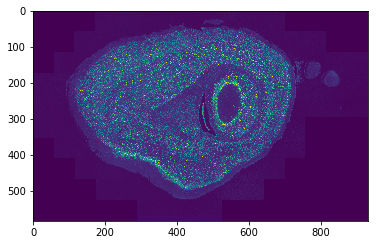

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S1_thumbnail_NtbNormalized.tif


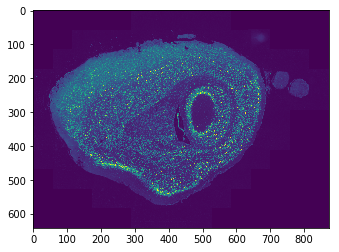

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S2_thumbnail_NtbNormalized.tif


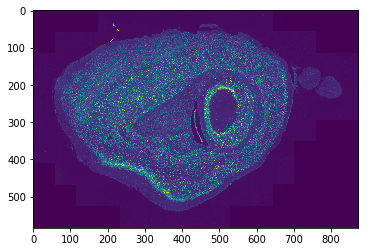

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S2_thumbnail_NtbNormalized.tif


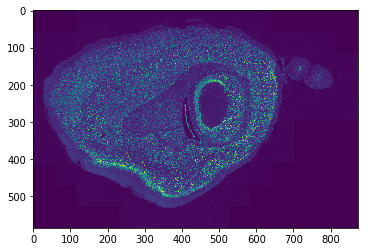

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S3_thumbnail_NtbNormalized.tif


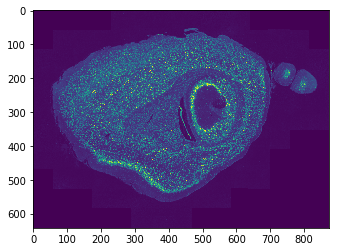

/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


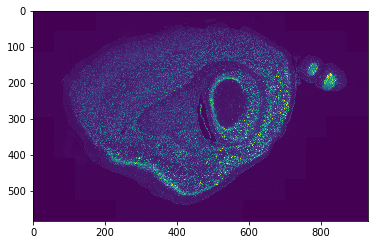

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S1_thumbnail_NtbNormalized.tif


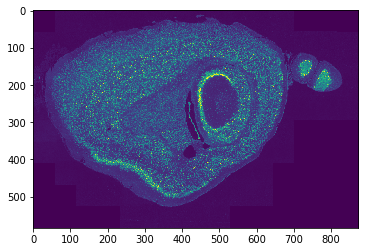

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S1_thumbnail_NtbNormalized.tif


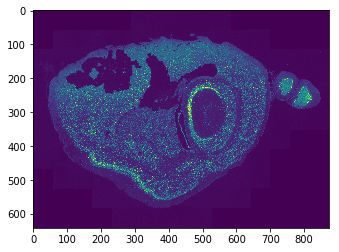

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S2_thumbnail_NtbNormalized.tif


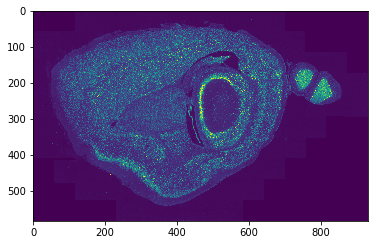

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S2_thumbnail_NtbNormalized.tif


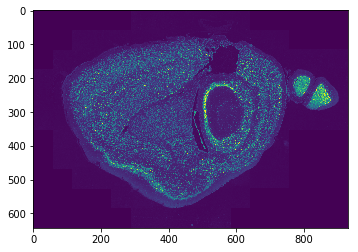

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S3_thumbnail_NtbNormalized.tif


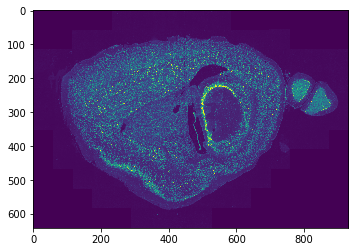

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S3_thumbnail_NtbNormalized.tif


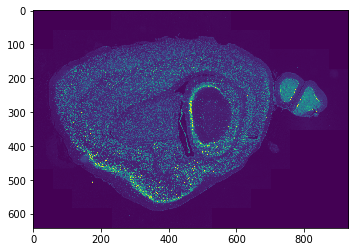

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S1_thumbnail_NtbNormalized.tif


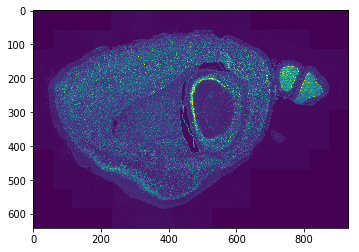

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S1_thumbnail_NtbNormalized.tif


KeyboardInterrupt: 

In [26]:
# rule_identifier = ('Ntb', 'raw')
rule_identifier = ('NtbNormalized', 'thumbnail')
version, resol = rule_identifier

for img_name in valid_filenames:
    img = DataManager.load_image_v2(stack=stack, prep_id=None, resol=resol, version=version, fn=img_name)
    plt.figure()
    plt.imshow(img);
    plt.show();

# Sort images

In [24]:
# filenames_to_sections, _ = DataManager.load_sorted_filenames(stack=stack)

# Align, compute transform between adjacent sections

In [9]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack, redownload=True) 
# Note that this could be the human-corrected version, in which case the transforms may not exist.
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
print len(valid_filenames), 'valid filenames'

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_sorted_filenames.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_sorted_filenames.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_sorted_filenames.txt"
0
235 valid filenames


In [29]:
print "Has file but not in ordered list:"
print set(image_names_all_data_dirs_flattened) - set(valid_filenames)

print "In ordered list but no file:"
print set(valid_filenames) - set(image_names_all_data_dirs_flattened)

set(['CHATM2_slide31_2018_01_19-S1'])
set([])


In [30]:
tb_fmt = 'tif'

In [31]:
version = 'NtbNormalized'

In [32]:
script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')
input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol='thumbnail')    
output_dir = create_if_not_exists(os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_elastix_output'))

In [33]:
! rm -fr "{output_dir}"

In [ ]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \"%(output_dir)s\" \'%%(kwargs_str)s\' %(fmt)s -p %(param_fp)s -r" % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt,
                 'param_fp': '/home/yuncong/Brain/preprocess/parameters/Parameters_Rigid_MutualInfo_noNumberOfSpatialSamples_4000Iters.txt'
                },
                kwargs_list=[{'prev_fn': valid_filenames[i-1] + '_thumbnail_' + version, 
                              'curr_fn': valid_filenames[i] + '_thumbnail_' + version,
                             'prev_sn': valid_filenames[i-1] ,
                             'curr_sn': valid_filenames[i] } 
                             for i in range(1, len(valid_filenames))],
                argument_type='list',
                jobs_per_node=8,
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 2252 seconds full stack

Align...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


In [41]:
upload_to_s3(output_dir, is_dir=True, local_root=DATA_ROOTDIR)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_elastix_output" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_elastix_output"
0


# Check alignment metrics

In [39]:
import re

final_metric = {}
for i in range(1, len(valid_filenames)):
#     if stack == 'ChatCryoJane201710':
#         prev_fn = valid_filenames[i-1] + '-Ntb'
#         curr_fn = valid_filenames[i] + '-Ntb'
#     else:
    prev_fn = valid_filenames[i-1]
    curr_fn = valid_filenames[i]

    with open(os.path.join(output_dir, curr_fn + '_to_' + prev_fn, 'elastix.log'), 'r') as f:
        t = f.read()
        g = re.search("Final metric value  = (.*?)\n", t)
#         final_metric[(curr_fn, prev_fn)] = -float(g.groups()[0])
        if g is None:
            print i
        final_metric[i] = float(g.groups()[0])

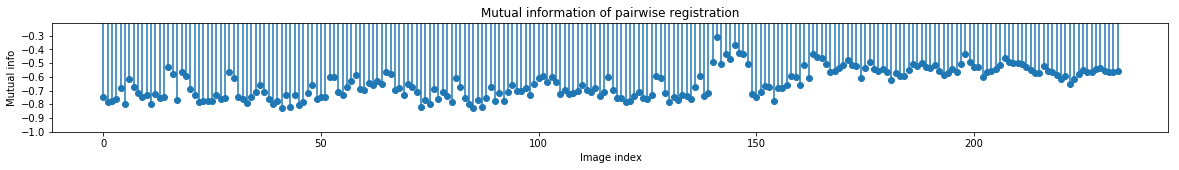

In [40]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,2));
plt.ylim([-1, metric_arr.max()+.1]);
plt.stem(metric_arr);
plt.title('Mutual information of pairwise registration');
plt.yticks(np.arange(-1, metric_arr.max()+.1, 0.1));
plt.xlabel('Image index');
plt.ylabel('Mutual info');

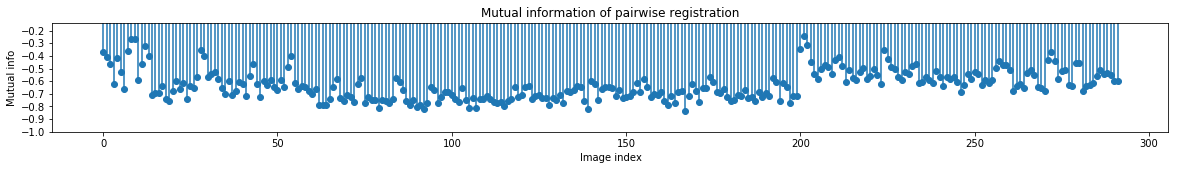

In [145]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,2));
plt.ylim([-1, metric_arr.max()+.1]);
plt.stem(metric_arr);
plt.title('Mutual information of pairwise registration');
plt.yticks(np.arange(-1, metric_arr.max()+.1, 0.1));
plt.xlabel('Image index');
plt.ylabel('Mutual info');

In [42]:
problematic_moving_indices = np.where(abs(metric_arr) < .6)[0] + 1

problematic_pairs = [(valid_filenames[moving_ind-1], valid_filenames[moving_ind]) 
                     for moving_ind in problematic_moving_indices]

print 'Pairs to check (fixed, moving):'
problematic_pairs

Pairs to check (fixed, moving):


[('CHATM2_slide06_2018_01_18-S2', 'CHATM2_slide05_2018_01_18-S3'),
 ('CHATM2_slide05_2018_01_18-S3', 'CHATM2_slide06_2018_01_18-S3'),
 ('CHATM2_slide07_2018_01_18-S1', 'CHATM2_slide08_2018_01_18-S1'),
 ('CHATM2_slide08_2018_01_18-S1', 'CHATM2_slide07_2018_01_18-S2'),
 ('CHATM2_slide10_2018_01_18-S3', 'CHATM2_slide11_2018_01_18-S1'),
 ('CHATM2_slide17_2018_01_18-S3', 'CHATM2_slide18_2018_01_18-S3'),
 ('CHATM2_slide19_2018_01_18-S3', 'CHATM2_slide20_2018_01_18-S3'),
 ('CHATM2_slide22_2018_01_19-S3', 'CHATM2_slide23_2018_01_18-S1'),
 ('CHATM2_slide23_2018_01_18-S1', 'CHATM2_slide24_2018_01_18-S1'),
 ('CHATM2_slide35_2018_01_20-S1', 'CHATM2_slide36_2018_01_22-S1'),
 ('CHATM2_slide45_2018_01_22-S1', 'CHATM2_slide46_2018_01_22-S1'),
 ('CHATM2_slide50_2018_01_22-S1', 'CHATM2_slide49_2018_01_22-S2'),
 ('CHATM2_slide50_2018_01_22-S3', 'CHATM2_slide51_2018_01_22-S1'),
 ('CHATM2_slide51_2018_01_22-S1', 'CHATM2_slide52_2018_01_22-S1'),
 ('CHATM2_slide52_2018_01_22-S1', 'CHATM2_slide51_2018_01_22-S

In [128]:
script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')
input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol='thumbnail')    
output_dir = create_if_not_exists(os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_elastix_output'))
version = 'NtbNormalized'
tb_fmt = 'tif'

In [134]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \"%(output_dir)s\" \'%%(kwargs_str)s\' %(fmt)s -p %(param_fp)s -r" % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt,
                 'param_fp': '/home/yuncong/Brain/preprocess/parameters/Parameters_Rigid_MutualInfo_noNumberOfSpatialSamples_4000Iters.txt'
                },
                kwargs_list=[{'prev_fn': f + '_thumbnail_' + version, 
                              'curr_fn': m + '_thumbnail_' + version,
                             'prev_sn': f,
                             'curr_sn': m} 
                             for f, m in problematic_pairs[:1]],
                argument_type='list',
                jobs_per_node=8,
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 2252 seconds full stack

Align...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 121.798708916 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [135]:
! cat /home/yuncong/stderr_0.log

Result for aligning CHATM3_slide04_2018_02_17-S2_thumbnail_NtbNormalized to CHATM3_slide03_2018_02_18-S2_thumbnail_NtbNormalized already exists.


In [148]:
pp_fp = os.path.join(DATA_DIR, stack, stack + '_problematic_pairs.txt')

In [149]:
with open(pp_fp, 'w') as f:
    for moving_ind in problematic_moving_indices:
        f.write('%s %s\n' % (valid_filenames[moving_ind-1], valid_filenames[moving_ind]))

In [150]:
upload_to_s3(pp_fp)

aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_problematic_pairs.txt" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_problematic_pairs.txt"
0


In [79]:
q = np.argmin(np.abs(final_metric.values()))
print 'worst pair (moving, fixed):', valid_filenames[q], valid_filenames[q-1]

worst pair (moving, fixed): CHATM3_slide73_2018_01_26-S1 CHATM3_slide72_2018_02_19-S3


# Check and correct alignments

# Compose alignments

In [176]:
download_from_s3(os.path.join('CSHL_data_processed', stack, stack + '_custom_transforms'), 
                 is_dir=True, local_root=DATA_ROOTDIR, redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_custom_transforms" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_custom_transforms" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_custom_transforms"
0


In [69]:
download_from_s3(os.path.join('CSHL_data_processed', stack, stack + '_anchor.txt'), 
                     is_dir=False,
                    local_root=DATA_ROOTDIR)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_anchor.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_anchor.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_anchor.txt"
0


In [70]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)
anchor_idx = valid_filenames.index(anchor_fn)
print 'anchor_idx =', anchor_idx

anchor_idx = 164


In [71]:
script = os.path.join(REPO_DIR, 'preprocess', 'compose_transform_thumbnail_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')
output_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                         dict(stack=stack, anchor_fn=anchor_fn))

In [72]:
! rm -f "{output_fp}"

In [73]:
t = time.time()
print 'Composing transform...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \'%%(kwargs_str)s\' %(anchor_idx)d \"%(output_fp)s\"" % \
            {'stack': stack,
            'script': script,
            'input_dir': input_dir,
            'anchor_idx': anchor_idx,
            'output_fp': output_fp},
            kwargs_list=[{'filenames': valid_filenames}],
            argument_type='list',
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds

Composing transform...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 15.6110510826 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [74]:
upload_to_s3(output_fp)

aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_transformsTo_CHATM2_slide62_2018_02_14-S1.pkl" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_transformsTo_CHATM2_slide62_2018_02_14-S1.pkl"
0


# Transform

In [183]:
transforms_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                                dict(stack=stack, anchor_fn=anchor_fn))
download_from_s3(transforms_fp, redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl"
0


In [75]:
pad_bg_color = 'black'

In [76]:
prep_id = 1

In [77]:
version = 'NtbNormalized'

In [78]:
input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol='thumbnail')
out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, resol='thumbnail', version=version)
print 'out_dir:', out_dir
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

out_dir: /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized


In [79]:
! rm -rf {out_dir}

In [80]:
t = time.time()
print 'Warping...'

transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, anchor_fn=anchor_fn)

if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %%(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    },
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=None, version=version, resol='thumbnail'),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol='thumbnail'),
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)
else:
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=None, version=version, resol='thumbnail'),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol='thumbnail'),
                                 }
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)

# wait_qsub_complete()
    
print 'done in', time.time() - t, 'seconds' # 300 seconds.

Warping...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 147.302836895 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [81]:
upload_to_s3(out_dir, is_dir=True, local_root=DATA_ROOTDIR)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized"
0


# Check whether given image order is correct

In [52]:
out_dir = '/tmp/tmp_sorted_images'
execute_command('rm -r ' + out_dir)

rule_identifier = ('NtbNormalized', 'thumbnail')

version, resol = rule_identifier

for img_name, section_index in filenames_to_sections.iteritems():   
    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=1, resol=resol, version=version, fn=img_name)
    out_fp = os.path.join(out_dir, '%04d.tif' % section_index)
    create_parent_dir_if_not_exists(out_fp)
#     print in_fp, out_fp
    execute_command('ln -s %(in_fp)s %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp})
#     upload_to_s3(out_fp)

rm -r /tmp/tmp_sorted_images
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide66_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0192.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide50_2018_02_18-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0144.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide50_2018_02_18-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0146.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide50_2018_02_18-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0148.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide28_2018_02_17-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_im

0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide115_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0343.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide115_2018_01_26-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0341.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide60_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0174.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide71_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0209.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide71_2018_02_19-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0211.tif
0
ln -s /medi

ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide75_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0223.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide47_2018_02_18-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0137.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide119_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0355.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide65_2018_02_19-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0195.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide34_2018_02_17-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0100.tif
0
ln -s /media/y

ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide63_2018_02_19-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0187.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide14_2018_02_18-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0038.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide62_2018_02_19-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0182.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide62_2018_02_19-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0184.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide14_2018_02_18-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0040.tif
0
ln -s /media/yu

0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide17_2018_02_17-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0047.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide69_2018_02_19-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0207.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide27_2018_02_17-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0077.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide69_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0203.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide79_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0235.tif
0
ln -s /media/

0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide107_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0319.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide107_2018_01_26-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0321.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide107_2018_01_26-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0317.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide109_2018_01_26-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0327.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide35_2018_02_17-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0103.tif
0
ln -s /me

# Generate Masks (for aligned images)

- Download aligned thumbnails to local machine.
- Run `mask_editing_gui.py`. Draw initial contours. Upload `initSnakeContours.pkl` to S3.

In [5]:
download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=1, resol='thumbnail', version='Ntb'), is_dir=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_Ntb" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_Ntb" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_Ntb"
0


In [82]:
script = os.path.join(REPO_DIR, 'preprocess', 'generate_thumbnail_masks_v5.py')

output_dir = create_if_not_exists(DataManager.get_auto_submask_rootdir_filepath(stack=stack))
! rm -rf {output_dir} # important to clear remaining folders.

In [83]:
init_snake_contours_fp = DataManager.get_initial_snake_contours_filepath(stack=stack)
download_from_s3(init_snake_contours_fp, redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_initSnakeContours.pkl" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_initSnakeContours.pkl" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_initSnakeContours.pkl"
0


In [84]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack, redownload=True) 
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
print len(valid_filenames), 'valid filenames'

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_sorted_filenames.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_sorted_filenames.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_sorted_filenames.txt"
0
235 valid filenames


In [85]:
t = time.time()
print 'Generating thumbnail mask...',

min_size = 100 # pixel count

run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\' %(init_snake_contours_fp)s --min_size %(min_size)d --default_channel 1 --shrink 3 --version NtbNormalized' % \
                {'script_path': script,
                'stack': stack,
                'init_snake_contours_fp': init_snake_contours_fp,
                 'min_size': min_size
                },
                kwargs_list={
                    'filenames': valid_filenames
#                     'filenames': ['CHATM3_slide06_2018_02_17-S1']
                            },
                argument_type='list2',
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 300s (aws)

Generating thumbnail mask... rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 2175.32406902 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [86]:
# ! cat /home/yuncong/stderr_0.log

In [87]:
fns_processed = set(os.listdir(DataManager.get_auto_submask_rootdir_filepath(stack=stack)))
fns_failed = set(valid_filenames) - fns_processed

print 'Mask generation failed:'
print fns_failed

Mask generation failed:
set([])


- download the folder `autoSubmasks` from S3.
- Use local mask editing tool, generate `userModifiedSubmasks` and `masks`, upload to S3.

# Map masks back to original images

In [5]:
from data_manager import *
from metadata import *

In [6]:
from skimage.transform import warp

In [10]:
def get_original_thumbnail_from_prep1_thumbnail(img, stack, section=None, fn=None):
    
    Ts = DataManager.load_transforms_v2(stack, in_image_resolution='down32', out_image_resolution='down32',
                                   use_inverse=False)
    if fn is None:
        fn = metadata_cache['sections_to_filenames'][stack][section]
    
    img_warped = warp(img, inverse_map=Ts[fn])
    
    img_tb_raw = DataManager.load_image_v2(stack=stack, prep_id=None, 
                                             resol='thumbnail', version='NtbNormalized', 
                                             fn=fn)
    h, w = img_tb_raw.shape
    return img_warped[:h, :w].astype(img.dtype)

In [11]:
for fn in valid_filenames:
    
    mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
    mask_tb_original = get_original_thumbnail_from_prep1_thumbnail(mask_tb_alignedPadded, stack=stack, fn=fn)
    
#     img_tb_original = DataManager.load_image_v2(stack=stack, prep_id=None, 
#                                          resol='thumbnail', version='NtbNormalized', 
#                                          fn=fn)
    
    mask_tb_original_fp = DataManager.get_thumbnail_mask_filename_v3(stack, prep_id=None, fn=fn)
    create_parent_dir_if_not_exists(mask_tb_original_fp)
    imsave(mask_tb_original_fp, mask_tb_original)
    upload_to_s3(mask_tb_original_fp)

#     masked_img = img_tb_raw.copy()
#     masked_img[~mask_tb_raw] = 0
    
#     plt.figure()
#     plt.imshow(masked_img, cmap=plt.cm.gray);
#     plt.show()

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide01_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide01_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide02_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide02_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide01_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide01_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide01_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide01_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide01_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide02_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide02_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide01_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide01_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide01_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide01_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide01_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide02_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide02_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide02_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide03_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide03_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide04_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide04_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide04_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide04_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide03_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSH

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide04_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide04_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide04_2018_01_18-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide04_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSH

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide03_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide03_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide03_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide04_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide04_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide04_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide04_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide06_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide06_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide05_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide05_2018_01_18-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide06_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide06_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide05_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide05_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide05_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide06_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide06_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide06_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide07_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide07_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide07_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide07_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide08_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide08_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide07_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide07_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide07_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide07_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide07_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide08_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide08_2018_01_18-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide07_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide07_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide08_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide08_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide08_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide09_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide09_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide09_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide09_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide10_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide10_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide09_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide09_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide09_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide09_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide10_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide10_2018_01_18-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide09_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide09_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide09_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide09_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide10_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide10_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide10_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide11_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide11_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide12_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide12_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide11_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide11_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide12_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide12_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide11_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide11_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide11_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide12_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide12_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide12_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide13_2018_01_19-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide13_2018_01_19-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide13_2018_01_19-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide13_2018_01_19-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide14_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide14_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide13_2018_01_19-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide13_2018_01_19-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide13_2018_01_19-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide13_2018_01_19-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide14_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide14_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide13_2018_01_19-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide13_2018_01_19-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide13_2018_01_19-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide13_2018_01_19-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide13_2018_01_19-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide14_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide14_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide15_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide15_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide16_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSH

Not using image_cache.
Not using image_cache.



0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide15_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide15_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide16_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide16_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide15_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide15_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide16_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide16_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide16_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide17_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide17_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide18_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide18_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide17_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide17_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide17_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide17_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide18_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide18_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide17_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide17_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide17_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide17_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide17_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide18_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide18_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide18_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide19_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide19_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide20_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide20_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide19_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide19_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide20_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide20_2018_01_18-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide19_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide19_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide19_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide20_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide20_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide20_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide21_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide21_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide22_2018_01_19-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide22_2018_01_19-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide21_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSH

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide22_2018_01_19-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSH

Not using image_cache.
Not using image_cache.



0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide21_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide21_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide21_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide22_2018_01_19-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide22_2018_01_19-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide22_2018_01_19-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide23_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide23_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide24_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide24_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide23_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide23_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide24_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide24_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide23_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide23_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide24_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide24_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide25_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide25_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide25_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide25_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide26_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide26_2018_01_18-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide25_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide25_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide25_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide25_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide26_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide26_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide25_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide25_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide25_2018_01_18-S3_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S3_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide25_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide25_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide26_2018_01_18-S3_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/

Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide26_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide26_2018_01_18-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide27_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide27_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide28_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide28_2018_01_18-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide27_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide27_2018_01_18-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide28_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide28_2018_01_18-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide27_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide27_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide27_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide28_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide28_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide28_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide29_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSH

Not using image_cache.
Not using image_cache.



0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide30_2018_01_18-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CS

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide29_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide29_2018_01_18-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide30_2018_01_18-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide30_2018_01_18-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide29_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide29_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide29_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide30_2018_01_18-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide30_2018_01_18-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide30_2018_01_18-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide32_2018_01_20-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide32_2018_01_20-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide31_2018_01_19-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide31_2018_01_19-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide31_2018_01_19-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide31_2018_01_19-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide31_2018_01_19-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide32_2018_01_20-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide32_2018_01_20-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide31_2018_01_19-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide31_2018_01_19-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide31_2018_01_19-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide31_2018_01_19-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide34_2018_01_20-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide34_2018_01_20-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/

Not using image_cache.
Not using image_cache.



0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide33_2018_01_20-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide33_2018_01_20-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide34_2018_01_20-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide34_2018_01_20-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide34_2018_01_20-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide35_2018_01_20-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide35_2018_01_20-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide35_2018_01_20-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide35_2018_01_20-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide35_2018_01_20-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide35_2018_01_20-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide35_2018_01_20-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide35_2018_01_20-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide35_2018_01_20-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide35_2018_01_20-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide35_2018_01_20-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide35_2018_01_20-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide35_2018_01_20-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide36_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide36_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide37_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide37_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/

Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/

Not using image_cache.
Not using image_cache.



0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide44_2018_01_22-S3_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S3_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide44_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide44_2018_01_22-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide45_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide45_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide46_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide46_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide45_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide45_2018_01_22-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide46_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide46_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide45_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide45_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide45_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide46_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide46_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide46_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide48_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide48_2018_01_22-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.
Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide48_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide48_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide48_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide49_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide49_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide49_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide49_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide49_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide50_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide50_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSH

Not using image_cache.
Not using image_cache.



0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide68_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide68_2018_02_14-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide68_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide68_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide72_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide72_2018_02_14-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide72_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide72_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide72_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide72_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide72_2018_02_14-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide74_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide74_2018_02_14-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide74_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide74_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide74_2018_02_14-S3_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S3_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide74_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide74_2018_02_14-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide76_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide76_2018_02_14-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide76_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide76_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide76_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide76_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide76_2018_02_14-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S2_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_prep1_thumbnail_mask.png"
0
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S1_thumbnail_NtbNormalized.tif


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_process

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide84_2018_02_14-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide84_2018_02_14-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide86_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide86_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S2_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide86_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide86_2018_02_13-S2_thumbnail_mask.png"


Not using image_cache.


0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide86_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide86_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide86_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide90_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide90_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide90_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide90_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide90_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide90_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide90_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide92_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide92_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide92_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide92_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide92_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide92_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide92_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide94_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide94_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide94_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide94_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide94_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide94_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide94_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide96_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide96_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide96_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide96_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide96_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S3_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide96_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide96_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide98_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide98_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide98_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide98_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide98_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide98_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide98_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.
Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S1_thumbnail_NtbNormalized.tif
/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide100_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide100_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_p

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide100_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide100_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide100_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide100_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide100_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide102_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide102_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide102_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide102_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide102_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide102_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide102_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide104_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide104_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide104_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide104_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide104_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide104_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide104_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide106_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide106_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide106_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide106_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide106_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide106_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide106_2018_02_13-S3_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S1_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S1_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S1_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S1_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S1_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide108_2018_02_13-S1_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide108_2018_02_13-S1_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S2_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S2_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S2_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S2_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S2_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide108_2018_02_13-S2_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide108_2018_02_13-S2_thumbnail_mask.png"
0
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S3_prep1_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S3_prep1_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide108_2018_02_13-S3_prep1_thumbnail_mask.png"
0


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S3_thumbnail_NtbNormalized.tif


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S3_thumbnail_NtbNormalized.tif
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide108_2018_02_13-S3_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_thumbnail_mask/CHATM2_slide108_2018_02_13-S3_thumbnail_mask.png"
0


# Crop

In [191]:
download_from_s3(DataManager.get_cropbox_filename(stack), redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_alignedTo_CHATM3_slide77_2018_01_26-S1_cropbox.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_alignedTo_CHATM3_slide77_2018_01_26-S1_cropbox.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_alignedTo_CHATM3_slide77_2018_01_26-S1_cropbox.txt"
0


In [192]:
xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
w = xmax + 1 - xmin
h = ymax + 1 - ymin
x = xmin
y = ymin

print x,y,w,h

894 98 844 588


In [193]:
prep_id = 2

In [26]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [195]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)
transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, anchor_fn=anchor_fn)

In [196]:
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

In [197]:
pad_bg_color = 'black'

In [ ]:
# for version in ['CHAT']:
for version in ['Ntb']:

    t = time.time()

    if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
        run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s raw %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s -r \"%%(init_rotate)s\"' % \
                        {'script': script,
                        'stack': stack,
                         'x': x,
                        'y': y,
                        'w': w,
                        'h': h,
                        },
                        kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                    'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version=version, fn=img_name),
                                      'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=prep_id, version=version, resol='raw'),
                                    'pad_bg_color': 'black' if img_name.split('-')[1][0] == 'F' else 'white',
                                     'init_rotate': ''
                                     }
                                    for img_name in valid_filenames
                                    ],
                        argument_type='single',
                       jobs_per_node=1,
                       local_only=True)
    else:
        run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s raw %(x)d %(y)d %(w)d %(h)d %(pad_bg_color)s -r \"%%(init_rotate)s\"' % \
                        {'script': script,
                        'stack': stack,
                         'x': x,
                        'y': y,
                        'w': w,
                        'h': h,
                        'pad_bg_color': pad_bg_color
                        },
                        kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                    'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version=version, fn=img_name),
                                      'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=prep_id, version=version, resol='raw'),
                                      'init_rotate': ''
                                     }
                                    for img_name in valid_filenames
                                    ],
                        argument_type='single',
                       jobs_per_node=1,
                       local_only=True)

    # wait_qsub_complete()

    print 'done in', time.time() - t, 'seconds' # 300 seconds.

rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


# Brightness correction

`brightness_correction.ipynb`

# Generate thumbnail (for normalized images)

In [177]:
stack = 'CHATM2'

In [178]:
thumbnail_downscale_factor = 32

In [15]:
for img_name in metadata_cache['valid_filenames'][stack]:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version='NtbNormalizedAdaptive', fn=img_name)
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='thumbnail', version='NtbNormalizedAdaptive', fn=img_name)
    create_parent_dir_if_not_exists(out_fp)
    
    img = imread(in_fp)
    imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

    # Alternative: ImageMagick introduces an artificial noisy stripe in the output image.
#     cmd = 'convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp}
#     execute_command(cmd)
        
    sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

Rescale: 5.51 seconds.
Rescale: 5.20 seconds.
Rescale: 5.62 seconds.
Rescale: 5.17 seconds.
Rescale: 5.48 seconds.
Rescale: 5.65 seconds.
Rescale: 5.23 seconds.
Rescale: 5.58 seconds.
Rescale: 5.46 seconds.
Rescale: 5.44 seconds.
Rescale: 4.84 seconds.
Rescale: 5.65 seconds.
Rescale: 5.51 seconds.
Rescale: 5.45 seconds.
Rescale: 5.49 seconds.
Rescale: 5.49 seconds.
Rescale: 5.24 seconds.
Rescale: 5.48 seconds.
Rescale: 5.50 seconds.
Rescale: 5.59 seconds.
Rescale: 5.60 seconds.
Rescale: 5.96 seconds.
Rescale: 6.28 seconds.
Rescale: 6.04 seconds.
Rescale: 6.24 seconds.
Rescale: 6.05 seconds.
Rescale: 5.96 seconds.
Rescale: 5.98 seconds.
Rescale: 6.37 seconds.
Rescale: 6.46 seconds.
Rescale: 6.56 seconds.
Rescale: 6.31 seconds.
Rescale: 6.81 seconds.
Rescale: 6.79 seconds.
Rescale: 6.57 seconds.
Rescale: 7.29 seconds.
Rescale: 6.40 seconds.
Rescale: 6.83 seconds.
Rescale: 5.93 seconds.
Rescale: 6.86 seconds.
Rescale: 6.35 seconds.
Rescale: 7.21 seconds.
Rescale: 6.50 seconds.
Rescale: 6.

# Generate thumbnails (NtbNormalizedAdaptive)

In [54]:
thumbnail_downscale_factor = 32

In [58]:
for img_name in metadata_cache['valid_filenames'][stack]:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version='NtbNormalizedAdaptive', fn=img_name)
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='thumbnail', version='NtbNormalizedAdaptive', fn=img_name)
    create_parent_dir_if_not_exists(out_fp)
    
    img = imread(in_fp)
    imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])
        
    sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

Rescale: 5.50 seconds.
Rescale: 4.98 seconds.
Rescale: 5.35 seconds.
Rescale: 4.95 seconds.
Rescale: 5.29 seconds.
Rescale: 5.61 seconds.
Rescale: 5.30 seconds.
Rescale: 5.68 seconds.
Rescale: 5.01 seconds.
Rescale: 5.32 seconds.
Rescale: 6.15 seconds.
Rescale: 6.14 seconds.
Rescale: 6.38 seconds.
Rescale: 6.13 seconds.
Rescale: 6.34 seconds.
Rescale: 6.24 seconds.
Rescale: 5.68 seconds.
Rescale: 6.13 seconds.
Rescale: 5.79 seconds.
Rescale: 5.72 seconds.
Rescale: 8.32 seconds.
Rescale: 8.54 seconds.
Rescale: 8.10 seconds.
Rescale: 9.63 seconds.
Rescale: 8.37 seconds.
Rescale: 8.87 seconds.
Rescale: 8.49 seconds.
Rescale: 8.38 seconds.
Rescale: 9.06 seconds.
Rescale: 8.47 seconds.
Rescale: 7.87 seconds.
Rescale: 9.13 seconds.
Rescale: 11.52 seconds.
Rescale: 8.54 seconds.
Rescale: 6.63 seconds.
Rescale: 7.98 seconds.
Rescale: 9.88 seconds.
Rescale: 8.73 seconds.
Rescale: 8.66 seconds.
Rescale: 7.11 seconds.
Rescale: 9.20 seconds.
Rescale: 6.66 seconds.
Rescale: 9.66 seconds.
Rescale: 6

# Generate prep2 from raw

In [ ]:
# for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM2']:
for stack in ['CHATM2']:

    anchor_fn = DataManager.load_anchor_filename(stack=stack)
    transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, 
                                                       anchor_fn=anchor_fn)

    pad_bg_color = 'black'
#     pad_bg_color = 'white'

    new_prep_id = 2

    alignedBrainstemCrop_xmin, alignedBrainstemCrop_xmax,\
    alignedBrainstemCrop_ymin, alignedBrainstemCrop_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id='alignedBrainstemCrop',
                                                           return_dict=False, only_2d=True)

    x_tb = alignedBrainstemCrop_xmin
    y_tb = alignedBrainstemCrop_ymin
    w_tb = alignedBrainstemCrop_xmax - alignedBrainstemCrop_xmin + 1
    h_tb = alignedBrainstemCrop_ymax - alignedBrainstemCrop_ymin + 1
    
    for version in ['CHAT']:
#     for version in ['NtbNormalizedAdaptiveInvertedGamma']:
        for resol in ['raw']:
        
            out_version = version + 'Jpeg'
            
            input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol=resol)
            out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=new_prep_id, version=out_version, 
                                                   resol=resol)
            print 'out_dir:', out_dir
            script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

            # ! rm -rf {out_dir}
            
            create_if_not_exists(out_dir)

            t = time.time()

            if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
                run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %%(pad_bg_color)s' % \
                                {'script': script,
                                'stack': stack,
                                 'x_tb': x_tb,
                                'y_tb': y_tb,
                                'w_tb': w_tb,
                                'h_tb': h_tb,
                                 'resol': resol
                                },
                                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                            'input_fp':\
                                              DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                                resol=resol, 
                                                                                version=version, 
                                                                                fn=img_name),
                                            'output_fp':\
                                              DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                                prep_id=new_prep_id, 
                                                                                version=out_version, 
                                                                                resol=resol),
                                            'pad_bg_color': 'black' if img_name.split('-')[1][0] == 'F' else 'white',
                                             }
                                            for img_name in metadata_cache['valid_filenames'][stack]
#                                              for img_name in ['CHATM2_slide15_2018_01_18-S1']
                                            ],
                                argument_type='single',
                               jobs_per_node=1,
                               local_only=True)
            else:
                run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %(pad_bg_color)s' % \
                                {'script': script,
                                'stack': stack,
                                 'x_tb': x_tb,
                                'y_tb': y_tb,
                                'w_tb': w_tb,
                                'h_tb': h_tb,
                                 'resol': resol,
                                'pad_bg_color': pad_bg_color
                                },
                                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                            'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                                          resol=resol, version=version, 
                                                                                          fn=img_name),
                                            'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                                           prep_id=new_prep_id, 
                                                                                           version=out_version, 
                                                                                           resol=resol),
                                             }
                                            for img_name in metadata_cache['valid_filenames'][stack]
#                                               for img_name in ['CHATM2_slide15_2018_01_18-S1']
                                            ],
                                argument_type='single',
                               jobs_per_node=1,
                               local_only=True)

            # wait_qsub_complete()
            for img_name in metadata_cache['valid_filenames'][stack]:
                output_fp = DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                                           prep_id=new_prep_id, 
                                                                                           version=out_version, 
                                                                                           resol=resol)
                upload_to_s3(output_fp)

            print 'done in', time.time() - t, 'seconds'

out_dir: /data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide27_2018_02_17-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide27_2018_02_17-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide28_2018_02_17-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide28_2018_02_17-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide27_2018_02_17-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide27_2018_02_17-S3_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide28_2018_02_17-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide28_2018_02_

0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide40_2018_02_18-S1_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide40_2018_02_18-S1_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide39_2018_02_19-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide39_2018_02_19-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide40_2018_02_18-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide40_2018_02_18-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide39_2018_02_19-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide39_2018_0

0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide51_2018_02_18-S1_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide51_2018_02_18-S1_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide52_2018_02_19-S1_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide52_2018_02_19-S1_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide51_2018_02_18-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide51_2018_02_18-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide51_2018_02_18-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide51_2018_0

0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide62_2018_02_19-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide62_2018_02_19-S3_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide63_2018_02_19-S1_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide63_2018_02_19-S1_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide64_2018_02_19-S1_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide64_2018_02_19-S1_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide63_2018_02_19-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide63_2018_0

0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide75_2018_01_26-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide75_2018_0

0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide99_2018_01_26-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide99_2018_01_26-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide99_2018_01_26-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide99_2018_01_26-S3_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide101_2018_01_26-S1_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide101_2018_01_26-S1_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide101_2018_01_26-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide101_20

0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide121_2018_01_26-S2_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide121_2018_01_26-S2_prep2_raw_CHATJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide121_2018_01_26-S3_prep2_raw_CHATJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_CHATJpeg/CHATM3_slide121_2018_01_26-S3_prep2_raw_CHATJpeg.jpg"


# Identify bounding box of "wholebrainWithMargin"

In [26]:
for stack in ['CHATM2', 'CHATM3']:
    
    bbox_all_images = []
    for fn in metadata_cache['valid_filenames'][stack]:
        mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
        bbox = bbox_2d(mask_tb_alignedPadded)
        bbox_all_images.append(bbox)
    bbox_all_images = np.array(bbox_all_images)

#     bbox_all_images = np.array([
#         bbox_2d(DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn))
#         for fn in metadata_cache['valid_filenames'][stack]
#     ])
    
    margin = 5
    alignedWithMargin_xmin, alignedWithMargin_ymin = np.maximum(bbox_all_images[:, [0,2]].min(axis=0) - margin, 0)
    alignedWithMargin_xmax, alignedWithMargin_ymax = np.minimum(bbox_all_images[:, [1,3]].max(axis=0) + margin, 
                                                                [mask_tb_alignedPadded.shape[1]-1, mask_tb_alignedPadded.shape[0]-1])
    
    print alignedWithMargin_xmin, alignedWithMargin_xmax, alignedWithMargin_ymin, alignedWithMargin_ymax 
    
    alignedWithMargin_cropbox = {'rostral_limit': alignedWithMargin_xmin, 'caudal_limit': alignedWithMargin_xmax, 
 'dorsal_limit': alignedWithMargin_ymin, 'ventral_limit': alignedWithMargin_ymax}
    
    save_data(alignedWithMargin_cropbox, 
              DataManager.get_cropbox_filename_v2(stack=stack, anchor_fn=None, prep_id='alignedWithMargin'))

0 1527 1 733
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_alignedTo_CHATM2_slide62_2018_02_14-S1_prep5_cropbox.json" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_alignedTo_CHATM2_slide62_2018_02_14-S1_prep5_cropbox.json"
0
6 1921 16 924
aws s3 cp "/data/CSHL_data_processed/CHATM3/CHATM3_alignedTo_CHATM3_slide77_2018_01_26-S1_prep5_cropbox.json" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_alignedTo_CHATM3_slide77_2018_01_26-S1_prep5_cropbox.json"
0


In [ ]:
for fn in metadata_cache['valid_filenames'][stack]:
    mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
    plt.figure();
    plt.imshow(mask_tb_alignedPadded[alignedWithMargin_ymin:alignedWithMargin_ymax+1, 
                                     alignedWithMargin_xmin:alignedWithMargin_xmax+1], cmap=plt.cm.gray)
    plt.show();

# Generate prep5 thumbnails from prep1 thumbnails

In [ ]:
for stack in ['CHATM2', 'CHATM3']:

    alignedWithMargin_xmin, alignedWithMargin_xmax,\
    alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id='alignedWithMargin',
                                                           return_dict=False, only_2d=True)
            
    for section in metadata_cache['valid_sections_all'][stack]:
        
        for version in ['NtbNormalized', 'mask']:

            in_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=1, section=section, version=version, resol='thumbnail')

            out_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=5, section=section, version=version, resol='thumbnail')

            create_parent_dir_if_not_exists(out_fp)

            t = time.time()

            im_prep1 = imread(in_fp)
            im_prep5 = im_prep1[alignedWithMargin_ymin:alignedWithMargin_ymax+1, 
                                alignedWithMargin_xmin:alignedWithMargin_xmax+1]        
            save_data(im_prep5, out_fp)
            
            sys.stderr.write('Generate prep5: %.2f seconds.\n' % (time.time() - t))

# Generate prep5 from raw (transform + crop)

In [11]:
# for stack in ['CHATM2', 'CHATM3']:
for stack in ['CHATM2']:

    anchor_fn = DataManager.load_anchor_filename(stack=stack)
    transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, 
                                                       anchor_fn=anchor_fn)

    # pad_bg_color = 'black'
    pad_bg_color = 'white'
    version = 'NtbNormalizedAdaptiveInvertedGamma'

    new_prep_id = 5

    alignedWithMargin_xmin, alignedWithMargin_xmax,\
    alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id='alignedWithMargin',
                                                           return_dict=False, only_2d=True)

    x_tb = alignedWithMargin_xmin
    y_tb = alignedWithMargin_ymin
    w_tb = alignedWithMargin_xmax - alignedWithMargin_xmin + 1
    h_tb = alignedWithMargin_ymax - alignedWithMargin_ymin + 1
    
    for resol in ['raw']:

        input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol=resol)
        out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=new_prep_id, resol=resol, version=version)
        print 'out_dir:', out_dir
        script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

        # ! rm -rf {out_dir}

        # for version in ['CHAT']:
        for version in ['NtbNormalizedAdaptiveInvertedGamma']:

            t = time.time()

            if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
                run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %%(pad_bg_color)s' % \
                                {'script': script,
                                'stack': stack,
                                 'x_tb': x_tb,
                                'y_tb': y_tb,
                                'w_tb': w_tb,
                                'h_tb': h_tb,
                                 'resol': resol
                                },
                                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                            'input_fp':\
                                              DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                                resol=resol, version=version, 
                                                                                fn=img_name),
                                            'output_fp':\
                                              DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                                prep_id=new_prep_id, version=version, 
                                                                                resol=resol),
                                            'pad_bg_color': 'black' if img_name.split('-')[1][0] == 'F' else 'white',
                                             }
                                            for img_name in metadata_cache['valid_filenames'][stack]
#                                              for img_name in ['CHATM2_slide15_2018_01_18-S1']
                                            ],
                                argument_type='single',
                               jobs_per_node=1,
                               local_only=True)
            else:
                run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %(pad_bg_color)s' % \
                                {'script': script,
                                'stack': stack,
                                 'x_tb': x_tb,
                                'y_tb': y_tb,
                                'w_tb': w_tb,
                                'h_tb': h_tb,
                                 'resol': resol,
                                'pad_bg_color': pad_bg_color
                                },
                                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                            'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                                          resol=resol, version=version, 
                                                                                          fn=img_name),
                                            'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                                           prep_id=new_prep_id, version=version, 
                                                                                           resol=resol),
                                             }
                                            for img_name in metadata_cache['valid_filenames'][stack]
#                                               for img_name in ['CHATM2_slide15_2018_01_18-S1']
                                            ],
                                argument_type='single',
                               jobs_per_node=1,
                               local_only=True)

            # wait_qsub_complete()

            print 'done in', time.time() - t, 'seconds'

out_dir: /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 18474.5260539 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [ ]:
# Compress to JPEG

for stack in ['CHATM2']:
# for stack in ['CHATM2', 'CHATM3']:

    for section in metadata_cache['valid_sections'][stack]:

        in_fp = \
        DataManager.get_image_filepath_v2(stack=stack, prep_id=5, section=section, version='NtbNormalizedAdaptiveInvertedGamma', resol='raw')

        out_fp = \
        DataManager.get_image_filepath_v2(stack=stack, prep_id=5, section=section, version='NtbNormalizedAdaptiveInvertedGammaJpeg', resol='raw', ext='jpg')

        create_parent_dir_if_not_exists(out_fp)

        t = time.time()
        execute_command("convert %(in_fp)s %(out_fp)s" % {'in_fp': in_fp, 'out_fp': out_fp})
        sys.stderr.write('Convert to JPEG: %.2f seconds.\n' % (time.time() - t)) # 14s

        upload_to_s3(out_fp)

convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide15_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 40.30 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide16_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 37.97 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide15_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 37.22 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide16_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 40.09 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide15_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 37.07 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide16_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 35.96 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide17_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.08 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide18_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 35.71 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide17_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 37.15 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide18_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.11 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide17_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide17_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.44 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide18_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide18_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.86 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide19_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.92 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide20_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.08 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide19_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.51 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide20_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 40.49 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide19_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide19_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.44 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide20_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide20_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 35.63 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide21_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 41.56 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide22_2018_01_19-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 41.16 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide21_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 38.51 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide22_2018_01_19-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 41.32 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide21_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 40.93 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide22_2018_01_19-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S3_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 36.72 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide23_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide23_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide23_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide23_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 40.82 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide24_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide24_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide24_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide24_2018_01_18-S1_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 40.85 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide23_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide23_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide23_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide23_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"


Convert to JPEG: 37.41 seconds.


0
convert /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide24_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGamma.tif /data/CSHL_data_processed/CHATM2/CHATM2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide24_2018_01_18-S2_prep5_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


# Generate thumbnails (prep 5) from prep5 raw

In [151]:
thumbnail_downscale_factor = 32

In [ ]:
for stack in ['CHATM2', 'CHATM3']:
#     stack = 'CHATM2'

    for img_name in metadata_cache['valid_filenames'][stack]:
#     for img_name in ['CHATM2_slide66_2018_02_14-S1']:

        t = time.time()

        in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='raw', version='NtbNormalizedAdaptiveInvertedGamma', fn=img_name)
        out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='thumbnail', version='NtbNormalizedAdaptiveInvertedGamma', fn=img_name)
        create_parent_dir_if_not_exists(out_fp)

        img = imread(in_fp)
        imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

#         execute_command('convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp':in_fp, 'out_fp':out_fp})

        sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

Rescale: 12.55 seconds.
Rescale: 12.13 seconds.
Rescale: 12.10 seconds.
Rescale: 12.14 seconds.
Rescale: 12.04 seconds.
Rescale: 11.82 seconds.
Rescale: 11.96 seconds.
Rescale: 11.84 seconds.
Rescale: 11.78 seconds.
Rescale: 12.07 seconds.
Rescale: 11.77 seconds.
Rescale: 11.66 seconds.
Rescale: 11.79 seconds.
Rescale: 11.52 seconds.
Rescale: 11.48 seconds.
Rescale: 11.25 seconds.
Rescale: 11.06 seconds.
Rescale: 11.05 seconds.
Rescale: 11.15 seconds.
Rescale: 11.22 seconds.
Rescale: 11.57 seconds.
Rescale: 10.90 seconds.
Rescale: 11.03 seconds.
Rescale: 10.92 seconds.
Rescale: 10.50 seconds.
Rescale: 10.92 seconds.
Rescale: 10.61 seconds.
Rescale: 10.82 seconds.
Rescale: 10.75 seconds.
Rescale: 10.80 seconds.
Rescale: 10.86 seconds.
Rescale: 10.72 seconds.
Rescale: 10.45 seconds.
Rescale: 10.49 seconds.
Rescale: 10.49 seconds.
Rescale: 10.57 seconds.
Rescale: 10.23 seconds.
Rescale: 10.14 seconds.
Rescale: 9.92 seconds.
Rescale: 9.86 seconds.


# Crop, generate prep2 from prep5

In [12]:
from multiprocess import Pool

In [13]:
def f(stack, img_name, version, resol, x,y,w,h):

    input_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol=resol, version=version, fn=img_name)
    output_fp = DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=2, version=version, resol=resol)

    img = imread(input_fp)
    save_data(img[y:y+h, x:x+w], output_fp)

In [14]:
# for stack in ['CHATM2', 'CHATM3']:
for stack in ['CHATM2']:

    alignedBrainstemCrop_xmin, alignedBrainstemCrop_xmax, \
    alignedBrainstemCrop_ymin, alignedBrainstemCrop_ymax = DataManager.load_cropbox_v2(stack=stack, prep_id='alignedBrainstemCrop', only_2d=True)

    alignedWithMargin_xmin, alignedWithMargin_xmax,\
    alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id='alignedWithMargin',
                                                           return_dict=False, only_2d=True)

    alignedBrainstemCrop_xmin_wrt_alignedWithMargin = alignedBrainstemCrop_xmin - alignedWithMargin_xmin
    alignedBrainstemCrop_xmax_wrt_alignedWithMargin = alignedBrainstemCrop_xmax - alignedWithMargin_xmin
    alignedBrainstemCrop_ymin_wrt_alignedWithMargin = alignedBrainstemCrop_ymin - alignedWithMargin_ymin
    alignedBrainstemCrop_ymax_wrt_alignedWithMargin = alignedBrainstemCrop_ymax - alignedWithMargin_ymin

    print alignedBrainstemCrop_xmin_wrt_alignedWithMargin,\
    alignedBrainstemCrop_xmax_wrt_alignedWithMargin,\
    alignedBrainstemCrop_ymin_wrt_alignedWithMargin,\
    alignedBrainstemCrop_ymax_wrt_alignedWithMargin

    x_tb = alignedBrainstemCrop_xmin_wrt_alignedWithMargin
    y_tb = alignedBrainstemCrop_ymin_wrt_alignedWithMargin
    w_tb = alignedBrainstemCrop_xmax_wrt_alignedWithMargin - alignedBrainstemCrop_xmin_wrt_alignedWithMargin + 1
    h_tb = alignedBrainstemCrop_ymax_wrt_alignedWithMargin - alignedBrainstemCrop_ymin_wrt_alignedWithMargin + 1

#     for version in ['NtbNormalizedAdaptiveInvertedGamma', 'CHAT']:
#     for version in ['CHAT']:
    for version in ['NtbNormalizedAdaptiveInvertedGamma']:
#     for version in ['mask']:
#         for resol in ['thumbnail']:
        for resol in ['raw']:
            
            if resol == 'raw':
                x = x_tb * 32
                y = y_tb * 32
                w = w_tb * 32
                h = h_tb * 32
            elif resol == 'thumbnail':
                x = x_tb
                y = y_tb
                w = w_tb
                h = h_tb
            else:
                raise

#             input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=5, version=version, resol='raw')
            out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=2, resol=resol, version=version)
            print 'out_dir:', out_dir
#             script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

    #         ! rm -rf {out_dir}
            create_if_not_exists(out_dir)

            t = time.time()

            pool = Pool(8)
            _ = pool.map(lambda img_name: f(stack=stack, img_name=img_name, version=version, resol=resol, 
                                            x=x, y=y, w=w, h=h), 
                         metadata_cache['valid_filenames'][stack])
            pool.close()
            pool.join()

#             for img_name in metadata_cache['valid_filenames'][stack]:
#                 f(stack=stack, img_name=img_name, version=version, resol=resol, 
#                                             x=x, y=y, w=w, h=h)

        #     run_distributed('convert \"%%(input_fp)s\" -crop %(w)dx%(h)d+%(x)d+%(y)d  \"%%(output_fp)s\"' % \
        #                     {'w':w_raw, 'h':h_raw, 'x':x_raw, 'y':y_raw},
        #                     kwargs_list=[{'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='raw', version=version, fn=img_name),
        #                                   'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=2, version=version, resol='raw')}
        #                                  for img_name in metadata_cache['valid_filenames'][stack]],
        # #                                  for img_name in ['CHATM3_slide35_2018_02_17-S1']],
        #                     argument_type='single',
        #                    jobs_per_node=1,
        #                    local_only=True)

            # wait_qsub_complete()

            print 'done in', time.time() - t, 'seconds' # 1500s

553 1441 110 683
out_dir: /data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma


/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2543: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return numpy.fromstring(x, typecode)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2543: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return numpy.fromstring(x, typecode)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2543: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return numpy.fromstring(x, typecode)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2543: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return numpy.

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide15_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide15_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide17_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide17_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide29_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide16_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide16_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide19_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide19_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide22_2018_01_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInverte

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide34_2018_01_20-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide34_2018_01_20-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide30_2018_01_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide30_2018_01_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
0
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide28_2018_01_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInverte

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide37_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide37_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide31_2018_01_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide31_2018_01_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide33_2018_01_20-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGam

0
0
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide41_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide41_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide39_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide39_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide43_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInv

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide62_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide62_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
0
0
0
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide54_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide54_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide74_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveI

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide76_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide76_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
0
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide55_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide55_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
0
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide76_2018_02_14-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveI

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide102_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide102_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
0
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide86_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide86_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide98_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInver

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide88_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide88_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide104_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM2_slide104_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
0
done in 1522.92372203 seconds


In [16]:
# Compress to JPEG

# for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM3']:
for stack in ['CHATM2']:

    for section in metadata_cache['valid_sections'][stack]:
        
#         for version in ['NtbNormalizedAdaptiveInvertedGamma', 'CHAT']:
        for version in ['NtbNormalizedAdaptiveInvertedGamma']:

#             in_fp = \
#             DataManager.get_image_filepath_v2(stack=stack, prep_id=2, section=section, version=version, resol='raw')

            out_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=2, section=section, version=version+'Jpeg', resol='raw', ext='jpg')

#             create_parent_dir_if_not_exists(out_fp)

#             t = time.time()
#             execute_command("convert %(in_fp)s %(out_fp)s" % {'in_fp': in_fp, 'out_fp': out_fp})
#             sys.stderr.write('Convert to JPEG: %.2f seconds.\n' % (time.time() - t)) # 14s

            upload_to_s3(out_fp)

aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide16_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide15_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide21_2018_01_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide22_2018_01_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide23_2018_01_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide29_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide29_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide30_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide30_2018_01_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide29_2018_01_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide37_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide37_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide38_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide38_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide37_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide46_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide46_2018_01_22-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide45_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide45_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide46_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide54_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide54_2018_01_22-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide55_2018_01_22-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide55_2018_01_22-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide56_2018_01_22-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide68_2018_02_14-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide68_2018_02_14-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide70_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide70_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide70_2018_02_14-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide84_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide84_2018_02_14-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide84_2018_02_14-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide84_2018_02_14-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide84_2018_02_14-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM

0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide98_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide98_2018_02_13-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide98_2018_02_13-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide98_2018_02_13-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
0
aws s3 cp "/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide100_2018_02_13-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHAT